In [1]:
from model import create_model

nn4_small2_pretrained = create_model()

Using TensorFlow backend.


In [2]:
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

In [3]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')
print('metadata created')
print(metadata)

metadata created
[images/Colin_Powell/Colin_Powell_0004.jpg
 images/Colin_Powell/Colin_Powell_0006.jpg
 images/Colin_Powell/Colin_Powell_0005.jpg
 images/Colin_Powell/Colin_Powell_0008.jpg
 images/Colin_Powell/Colin_Powell_0001.jpg
 images/Colin_Powell/Colin_Powell_0003.jpg
 images/Colin_Powell/Colin_Powell_0007.jpg
 images/Colin_Powell/Colin_Powell_0002.jpg
 images/Colin_Powell/Colin_Powell_0010.jpg
 images/Colin_Powell/Colin_Powell_0009.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0005.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0002.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0006.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0007.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0001.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0004.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0010.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0003.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0009.jpg
 ima

In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]


alignment = AlignDlib('shape_predictor_68_face_landmarks.dat')

#combined transformation
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [5]:
embedded = np.zeros((metadata.shape[0], 128))
real_name = {}

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    real_name[os.path.dirname(m.image_path()[7:])] = embedded[i]


In [6]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

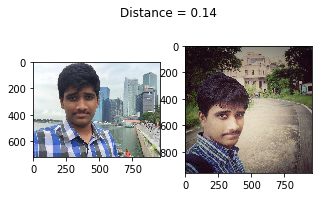

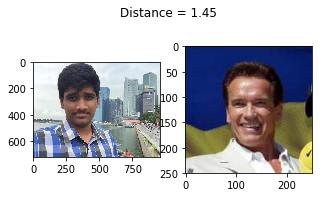

In [7]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(5,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(40, 41)
show_pair(40, 18)

In [19]:
def recognize(embedded):
    min_dist = 100
    _id = None
    for name,emb in real_name.items():
        dist = np.sum(np.square(emb - embedded))


        if dist < min_dist:
            min_dist = dist
            _id = name
#     if min_dist > 1.5:
#         return None
#     else:
    return _id

    

In [ ]:
embedded = np.zeros((1, 128))


def recognize_image(image_path):
    img = load_image(image_path)
    img = align_image(img)
    if img is not None:
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embedded = nn4_small2_pretrained.predict(np.expand_dims(np.array(img), axis=0))[0]
        name = recognize(embedded)
        print(name)
        return name
    return None


cap = cv2.VideoCapture(0)


def webcam_recognize():
    while(True): 
        ret, frame = cap.read()
        cv2.imwrite('temp.jpg',frame)
        cv2.waitKey(20)
        if 'temp.jpg' is not None:
            name = recognize_image('temp.jpg')
            cv2.imshow('temp',frame)
            print(name)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()


webcam_recognize()
# recognize_image('.jpg')




sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
Arnold_Schwarzenegger
None
None
None
None
None
None
None
None
None
None
None
None
None
